# Exercise 2.9: Convolutional Neural Networks - Age Prediction

Author: Sebastian Pritz

## Preparations

In [1]:
## adapt this directory to your needs
base_dir = './'
data_dir = base_dir + 'data/'

In [9]:
## if using Colab, you need to run this every time you start a notebook
## on a local installation, you only need to run this once (or install the
## pyMLaux package outside of the notebook once and for all)
#!pip install git+https://github.com/UBod/pyMLaux.git

In [2]:
import os, shutil
import random
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from pyMLaux import show_img_data, plot_history, evaluate_regression_result

In [3]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [12]:
## unzip data to local directory on Colab runtime
## (must be redone every time, since Colab kills the runtime's local memory each time )
#!cd ~; unzip -n $data_dir/age-prediction.zip

In [4]:
train_data_dir = data_dir + 'age-prediction/20-50/train/'
test_data_dir = data_dir + 'age-prediction/20-50/test/'

## From Scratch (1)

### Configure Generators (original resolution: 128 x 128)

In [14]:
batch_size = 64
img_size = (128, 128)

train_datagen = ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   validation_split=0.15,
                                   fill_mode='constant',
                                   cval=0)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    subset='training',
                                                    class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(train_data_dir,
                                                         target_size=img_size,
                                                         batch_size=batch_size,
                                                         subset='validation',
                                                         class_mode='sparse')

test_datagen = ImageDataGenerator(rescale=(1. / 255))

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='sparse')

Found 28432 images belonging to 31 classes.
Found 5000 images belonging to 31 classes.
Found 7008 images belonging to 31 classes.


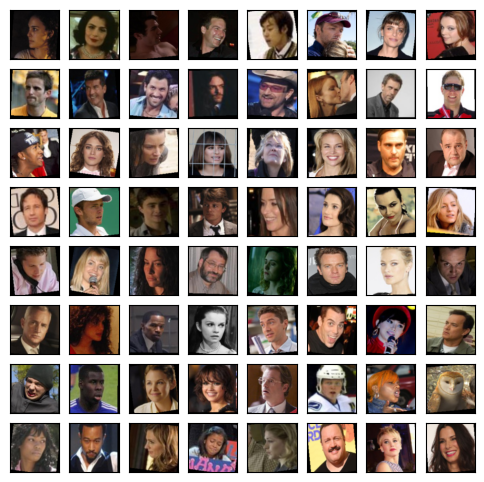

[[22. 41. 28. 46. 22. 26. 43. 26.]
 [25. 40. 25. 33. 46. 42. 38. 22.]
 [20. 27. 25. 23. 48. 25. 40. 47.]
 [49. 20. 21. 27. 34. 37. 32. 20.]
 [32. 26. 25. 41. 30. 40. 39. 34.]
 [45. 21. 35. 27. 32. 31. 22. 30.]
 [40. 21. 28. 29. 45. 21. 28. 32.]
 [44. 28. 38. 49. 22. 50. 23. 49.]]


In [15]:
for image_batch, label_batch in train_generator:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(6, 6))
    print(20 + label_batch.reshape((8, 8)))
    break

### Create Model (CNN Model to be trained from scratch)

Slightly adapt weights, Maxpooling and use GlobalAveragePooling instead of Flatten.

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((4, 4)),
    tf.keras.layers.Conv2D(256, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, (3, 3),
                           padding='same', activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation=None)
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      864       
                                                                 
 batch_normalization_17 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      9216      
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 128, 128, 32)     

### Train Model

In [34]:
filepath = base_dir + 'models/age-prediction/age-prediction_{epoch:02d}-{val_mae:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=1,
                                                save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(train_generator, epochs=5,
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/5
445/445 [==============================] - ETA: 0s - loss: 143.0372 - mae: 9.7153
Epoch 1: val_mae improved from inf to 7.55150, saving model to ./models/age-prediction\age-prediction_01-7.5515.hdf5
445/445 [==============================] - 79s 175ms/step - loss: 143.0372 - mae: 9.7153 - val_loss: 78.2330 - val_mae: 7.5515
Epoch 2/5
445/445 [==============================] - ETA: 0s - loss: 78.9298 - mae: 7.6152
Epoch 2: val_mae improved from 7.55150 to 7.53215, saving model to ./models/age-prediction\age-prediction_02-7.5322.hdf5
445/445 [==============================] - 78s 175ms/step - loss: 78.9298 - mae: 7.6152 - val_loss: 76.9377 - val_mae: 7.5322
Epoch 3/5
445/445 [==============================] - ETA: 0s - loss: 77.7002 - mae: 7.5406
Epoch 3: val_mae improved from 7.53215 to 7.51618, saving model to ./models/age-prediction\age-prediction_03-7.5162.hdf5
445/445 [==============================] - 78s 175ms/step - loss: 77.7002 - mae: 7.5406 - val_loss: 78.2022 - val_

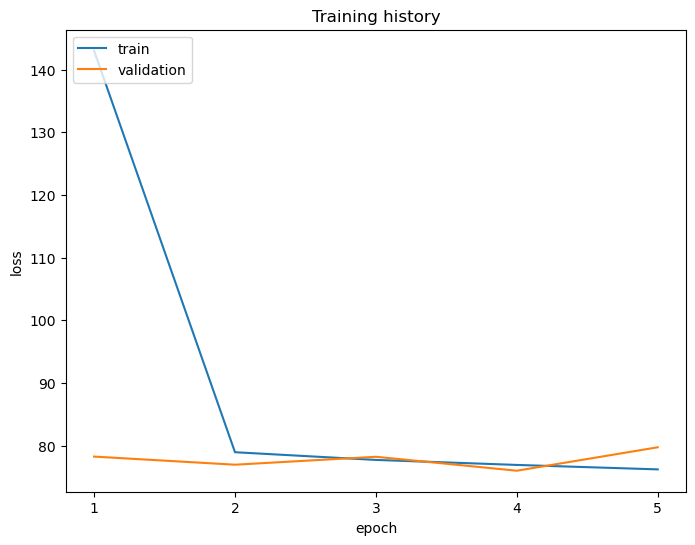

In [35]:
plot_history(history)

### Evaluate on Test Data (best model)

In [36]:
model_file = 'models/age-prediction/age-prediction_04-7.4759.hdf5'
model = tf.keras.models.load_model(model_file)

In [37]:
pred = model.predict(test_generator).reshape((len(test_generator.classes))) ## reshape() necessary to convert column vector to row vector

110/110 [==============================] - 4s 33ms/step


In [38]:
evaluate_regression_result(test_generator.classes + 20., pred + 20.);

Mean squared error (MSE): 76.99
Root mean squared error (RMSE): 8.77
Mean absolute error (MAE): 7.53
Coefficient of determination (R2): 0.05
Correlation coefficient (Pearson): 0.23 (p = 2.640801736711777e-82)


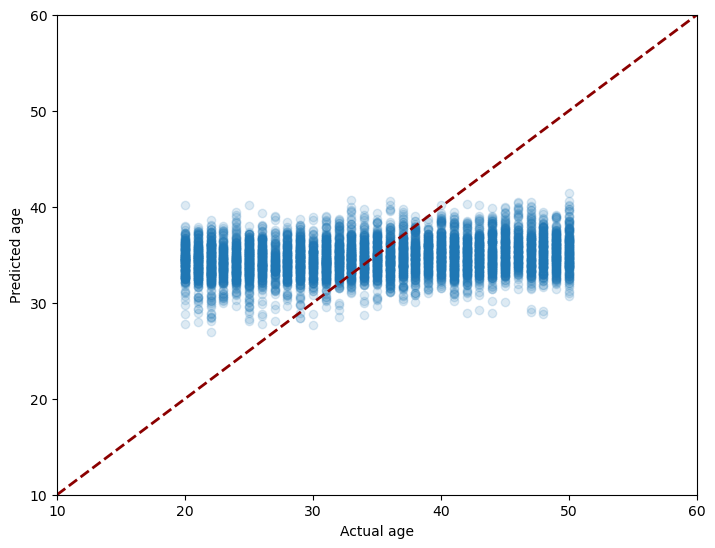

In [39]:
fig = plt.figure()
ax=fig.add_axes([0, 0, 1, 1])
ax.plot(np.array([10, 60]), np.array([10, 60]), linewidth=2, linestyle='dashed', color='darkred')
ax.scatter(test_generator.classes + 20., pred + 20., alpha=0.15)
ax.set_xlim(10, 60)
ax.set_ylim(10, 60)
ax.set_xlabel('Actual age')
ax.set_ylabel('Predicted age')
plt.show()

## Pretrained (2)

### Configure Generators (ImageNet resolution: 224 x 224)

In [40]:
batch_size = 64
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   validation_split=0.15,
                                   fill_mode='constant',
                                   cval=0)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    subset='training',
                                                    class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(train_data_dir,
                                                         target_size=img_size,
                                                         batch_size=batch_size,
                                                         subset='validation',
                                                         class_mode='sparse')

test_datagen = ImageDataGenerator(rescale=(1. / 255))

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='sparse')

Found 28432 images belonging to 31 classes.
Found 5000 images belonging to 31 classes.
Found 7008 images belonging to 31 classes.


### Create Model (fine-tuning pre-trained model)

In [41]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size[0], img_size[1], 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


Adding a small head to the model and finetuning it.

In [42]:
flat = tf.keras.layers.GlobalAveragePooling2D()(base_model.layers[-1].output)
dense = tf.keras.layers.Dense(64, activation='relu')(flat)
dropout = tf.keras.layers.Dropout(0.4)(dense)
output = tf.keras.layers.Dense(1, activation=None)(dropout)

model = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

### Fine-Tune Pre-Trained Model

In [44]:
filepath = base_dir + 'models/age-prediction/age-prediction_pre_{epoch:02d}-{val_mae:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=1,
                                                save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(train_generator, epochs=5,
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/5
445/445 [==============================] - ETA: 0s - loss: 79.2031 - mae: 7.4551
Epoch 1: val_mae improved from inf to 6.99386, saving model to ./models/age-prediction\age-prediction_pre_01-6.9939.hdf5
445/445 [==============================] - 204s 454ms/step - loss: 79.2031 - mae: 7.4551 - val_loss: 68.3992 - val_mae: 6.9939
Epoch 2/5
445/445 [==============================] - ETA: 0s - loss: 75.1813 - mae: 7.2423
Epoch 2: val_mae improved from 6.99386 to 6.94651, saving model to ./models/age-prediction\age-prediction_pre_02-6.9465.hdf5
445/445 [==============================] - 200s 450ms/step - loss: 75.1813 - mae: 7.2423 - val_loss: 67.8960 - val_mae: 6.9465
Epoch 3/5
445/445 [==============================] - ETA: 0s - loss: 73.8888 - mae: 7.1623
Epoch 3: val_mae improved from 6.94651 to 6.90141, saving model to ./models/age-prediction\age-prediction_pre_03-6.9014.hdf5
445/445 [==============================] - 198s 445ms/step - loss: 73.8888 - mae: 7.1623 - val_loss: 6

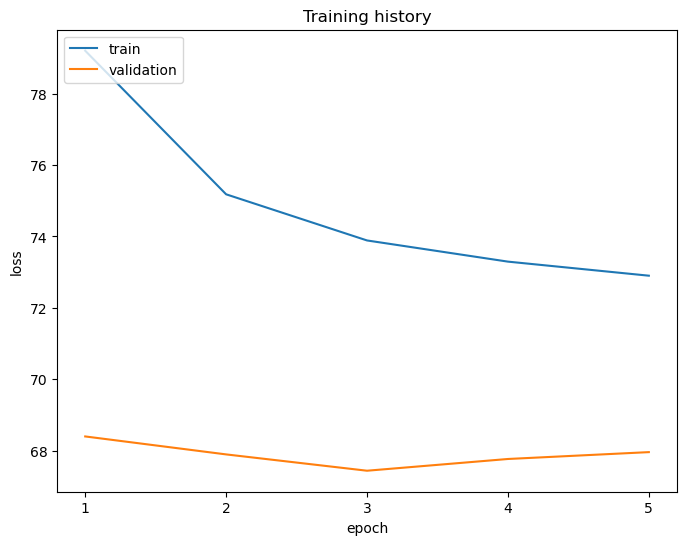

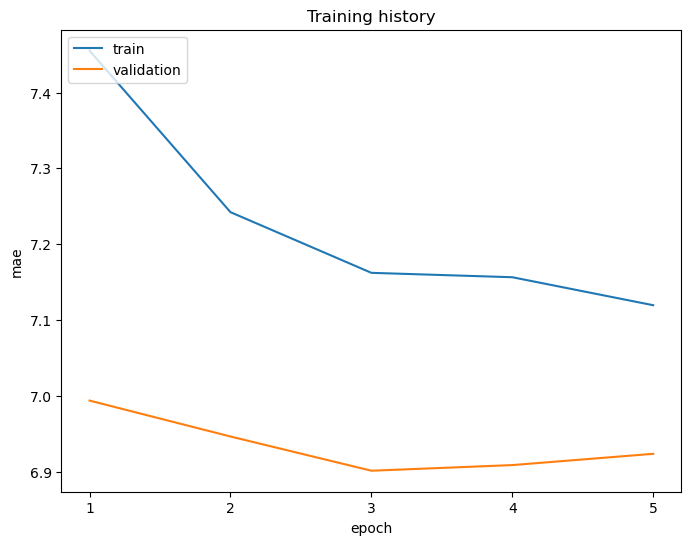

In [46]:
plot_history(history, measure='mae')

### Evaluate on Test Data (best model)

In [47]:
model_file = 'models/age-prediction/age-prediction_pre_03-6.9014.hdf5'
model = tf.keras.models.load_model(model_file)

In [48]:
pred = model.predict(test_generator).reshape((len(test_generator.classes))) ## reshape() necessary to convert column vector to row vector

110/110 [==============================] - 6s 46ms/step


In [49]:
evaluate_regression_result(test_generator.classes + 20., pred + 20.);

Mean squared error (MSE): 69.35
Root mean squared error (RMSE): 8.33
Mean absolute error (MAE): 7.03
Coefficient of determination (R2): 0.14
Correlation coefficient (Pearson): 0.38 (p = 1.2439337736698888e-239)


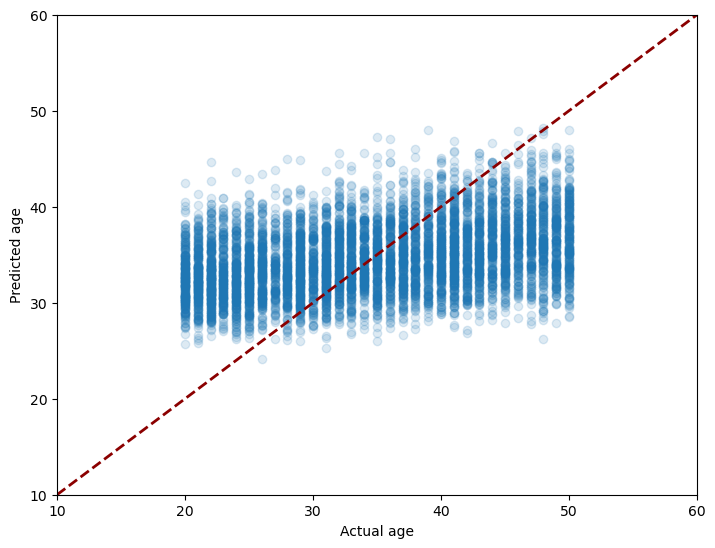

In [50]:
fig = plt.figure()
ax=fig.add_axes([0, 0, 1, 1])
ax.plot(np.array([10, 60]), np.array([10, 60]), linewidth=2, linestyle='dashed', color='darkred')
ax.scatter(test_generator.classes + 20., pred + 20., alpha=0.15)
ax.set_xlim(10, 60)
ax.set_ylim(10, 60)
ax.set_xlabel('Actual age')
ax.set_ylabel('Predicted age')
plt.show()

## Pretrained Trainable (3)

In [5]:
# leave generators the same, but for consistency, define again
batch_size = 64
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   validation_split=0.15,
                                   fill_mode='constant',
                                   cval=0)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    subset='training',
                                                    class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(train_data_dir,
                                                         target_size=img_size,
                                                         batch_size=batch_size,
                                                         subset='validation',
                                                         class_mode='sparse')

test_datagen = ImageDataGenerator(rescale=(1. / 255))

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='sparse')

Found 28432 images belonging to 31 classes.
Found 5000 images belonging to 31 classes.
Found 7008 images belonging to 31 classes.


### Create trainable model

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size[0], img_size[1], 3),
                                               include_top=False,
                                               weights='imagenet')

# this time, make it trainable
base_model.trainable = True

This time, make the whole model trainable.

In [7]:
dropout_pre = tf.keras.layers.Dropout(0.5)(base_model.layers[-1].output)
dense1 = tf.keras.layers.Dense(128, activation='relu')(dropout_pre)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
flat = tf.keras.layers.GlobalAveragePooling2D()(dense2)
dropout = tf.keras.layers.Dropout(0.3)(flat)
output = tf.keras.layers.Dense(1, activation=None)(dropout)

model = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

### Training

It should be mentioned, that I fitted the model before, for 5 epochs already, which is why the starting point is so low. I realized the epochs were not sufficient with this configuration (high dropout rates/multiple dropout layers) that aims to reduce overfitting.

In [10]:
filepath = base_dir + 'models/age-prediction/age-prediction_pre_trainable_{epoch:02d}-{val_mae:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=1,
                                                save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(train_generator, epochs=10,
                    validation_data=validation_generator, callbacks=callbacks_list)

Epoch 1/10
445/445 [==============================] - ETA: 0s - loss: 48.5888 - mae: 5.5907
Epoch 1: val_mae improved from inf to 6.78517, saving model to ./models/age-prediction\age-prediction_pre_trainable_01-6.7852.hdf5
445/445 [==============================] - 198s 445ms/step - loss: 48.5888 - mae: 5.5907 - val_loss: 71.9682 - val_mae: 6.7852
Epoch 2/10
445/445 [==============================] - ETA: 0s - loss: 47.4033 - mae: 5.5146
Epoch 2: val_mae did not improve from 6.78517
445/445 [==============================] - 198s 445ms/step - loss: 47.4033 - mae: 5.5146 - val_loss: 160.5338 - val_mae: 10.3537
Epoch 3/10
445/445 [==============================] - ETA: 0s - loss: 45.7693 - mae: 5.4197
Epoch 3: val_mae did not improve from 6.78517
445/445 [==============================] - 200s 450ms/step - loss: 45.7693 - mae: 5.4197 - val_loss: 130.3813 - val_mae: 9.2841
Epoch 4/10
445/445 [==============================] - ETA: 0s - loss: 44.6967 - mae: 5.3342
Epoch 4: val_mae did not 

### Evaluation

In [11]:
model_file = 'models/age-prediction/age-prediction_pre_trainable_07-6.2593.hdf5'
model = tf.keras.models.load_model(model_file)

In [12]:
pred = model.predict(test_generator).reshape((len(test_generator.classes))) ## reshape() necessary to convert column vector to row vector

110/110 [==============================] - 6s 46ms/step


In [13]:
evaluate_regression_result(test_generator.classes + 20., pred + 20.);

Mean squared error (MSE): 67.35
Root mean squared error (RMSE): 8.21
Mean absolute error (MAE): 6.36
Coefficient of determination (R2): 0.17
Correlation coefficient (Pearson): 0.57 (p = 0.0)


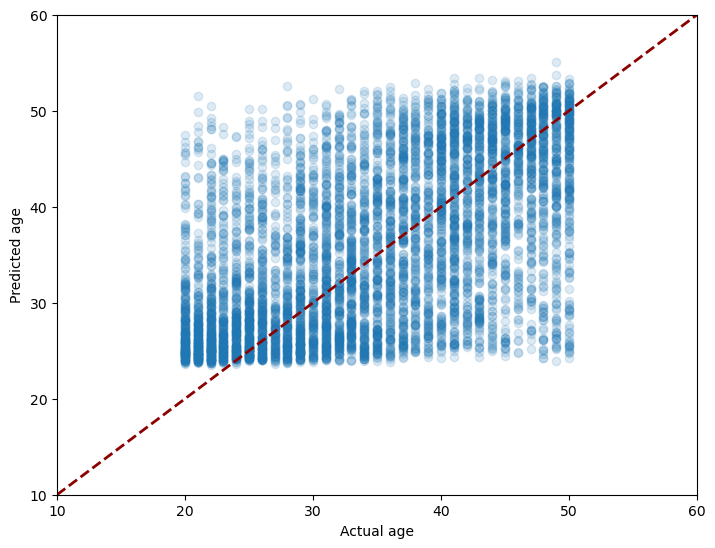

In [14]:
fig = plt.figure()
ax=fig.add_axes([0, 0, 1, 1])
ax.plot(np.array([10, 60]), np.array([10, 60]), linewidth=2, linestyle='dashed', color='darkred')
ax.scatter(test_generator.classes + 20., pred + 20., alpha=0.15)
ax.set_xlim(10, 60)
ax.set_ylim(10, 60)
ax.set_xlabel('Actual age')
ax.set_ylabel('Predicted age')
plt.show()